In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from NObSP_Decomposition import NObSP_NN_single_MultiOutput
from Classifier_NN import Classifier_NN
from torch.utils.data import DataLoader as tf_dataloader

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = tf_dataloader(trainset, batch_size=batch_size,
                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = tf_dataloader(testset, batch_size=batch_size,
                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


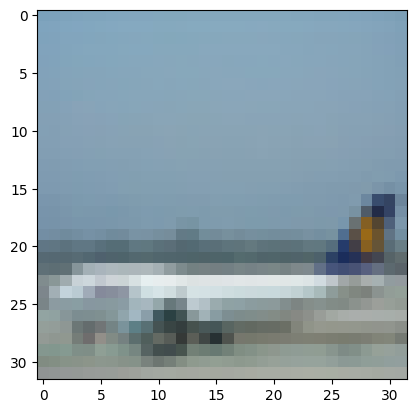

plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
def hook(module, input, output):
    output_tensors.append(output)

net.fc2.register_forward_hook(hook)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):  # loop over the dataset multiple times
    output_tensors = []
    running_loss = 0.0
    y = []
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        y.append(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10000 == 9999:    # print every 10000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1, 10000] loss: 9.897
[1, 20000] loss: 8.486
[1, 30000] loss: 8.001
[1, 40000] loss: 7.801
[1, 50000] loss: 7.660
[2, 10000] loss: 7.351
[2, 20000] loss: 7.269
[2, 30000] loss: 7.371
[2, 40000] loss: 7.230
[2, 50000] loss: 7.290
Finished Training


In [8]:
X = torch.cat(output_tensors, dim=0).detach()
y = torch.cat(y, dim=0)
y = torch.nn.functional.one_hot(y, num_classes=10)

In [9]:
N = np.size(X,0); # Defining the number of datapoints
in_feat = np.size(X,1)

In [10]:
t = np.arange(0, N)
train_split = int(0.8 * N)
p = 10

In [11]:
# Normalizing the input data
X_mean = torch.mean(X,dim=0) 
X_var = torch.var(X,dim=0)
X = (X-X_mean)/X_var

In [12]:
epochs = 1000
learning_rate = 0.02

In [13]:
# Split of the data for training and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size = train_split,
                                                    random_state=42) 


## Creating model for single nonlinear effects

model_1 = Classifier_NN(in_feat,p) # Creating the model
loss_fcn = nn.CrossEntropyLoss() # Definning loss function
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=learning_rate)  # Defining optimizer

# Training loop for the model 1

In [14]:
for epoch in range(epochs):
    model_1.train() # Setting the model in training mode
    y_prob, x_p, y_lin = model_1(X_train) #forward pass
    
    loss = loss_fcn(y_prob,
                    y_train.float())  # Compute Loss
    loss.backward() # compute backward
    optimizer.step() # update parameters
    optimizer.zero_grad() #zero grad optimizer
    
    ## Testing
    model_1.eval() # Setting the model in evalaution mode
    with torch.inference_mode():
        y_prob_pred, x_trans, y_lin_pred = model_1(X_test) # Estimating th emodel output in test data
    
    test_loss = loss_fcn(y_prob_pred,
                         y_test.float()) # Evaluating loss
    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | test Loss: {test_loss:.5f}') # Printing the performance of the model as it is trained

Epoch: 0 | Loss: 2.30260 | test Loss: 2.30266
Epoch: 100 | Loss: 2.30141 | test Loss: 2.30144
Epoch: 200 | Loss: 2.30013 | test Loss: 2.30013
Epoch: 300 | Loss: 2.29872 | test Loss: 2.29867
Epoch: 400 | Loss: 2.29710 | test Loss: 2.29699
Epoch: 500 | Loss: 2.29517 | test Loss: 2.29498
Epoch: 600 | Loss: 2.29278 | test Loss: 2.29244
Epoch: 700 | Loss: 2.28972 | test Loss: 2.28917
Epoch: 800 | Loss: 2.28591 | test Loss: 2.28508
Epoch: 900 | Loss: 2.28153 | test Loss: 2.28039


In [15]:
model_1.eval() # Setting the model in evaluation mode
with torch.inference_mode():
    y_prob_1, x_trans_total_1, y_est_1 = model_1(X) # Computin ght enonlinear transformation of the input data X

P_xy_1, y_e_1, Alpha_NN_1 = NObSP_NN_single_MultiOutput(X, y_est_1, model_1) # Computing the decomposition iusing NObSP. The Alpha parameters are the weigths for the Interpretation Layer

y_e_Alpha_1 = np.zeros((N,in_feat,p))
for i in range(p):
    y_e_Alpha_1[:,:,i] = (x_trans_total_1@Alpha_NN_1[:,i*in_feat:i*in_feat+in_feat]) # Computing the decomposition using the Alpha coefficients, out-of-sample extension

y_e_1 = y_e_1.cpu()

: 

: 

In [ ]:
## Plotting the resutls
for i in range(p):
    plt.plot(t,y[:,i],t,y_prob_1[:,i]) # Estimated output vs real output
    plt.tight_layout()
    plt.show()